In [1]:
import numpy as np

k_arr = np.logspace(-5, np.log10(200), 1000)
z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))
z_pk = np.arange(0, 60, 0.2)


class_params = {'h': 0.6766,
                'omega_b': 0.0224178568132,
                'omega_cdm': 0.11934063901639999,
                'A_s': 2.097e-09,
                'n_s': 0.9652,
                'P_k_max_1/Mpc': 200,
                'output': 'dTk,mPk,tCl',
                'z_max_pk': 100}


In [2]:
from classy import Class

cl = Class()
cl.set(class_params)
cl.compute()

In [3]:
import numpy as np
import pyccl

pars = dict(omega_cdm=class_params['omega_cdm'], omega_b=class_params['omega_b'], 
            h=class_params['h'], n_s=class_params['n_s'], A_s=class_params['A_s'])

k_arr = np.logspace(-5, np.log10(200), 1000)
z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))
z_pk = np.arange(0, 60, 0.2)

def get_cosmo(pars=pars, classy_instance=None, z_bg=z_bg):
    cosmo = pyccl.Cosmology(Omega_c=pars['omega_cdm'],
        Omega_b=pars['omega_b'], h=pars['h'], n_s=pars['n_s'],
        A_s=pars['A_s'],
        transfer_function='boltzmann_camb')

    # Set background quantities in CCL using class arrays, if cosmology_helper is passed
    if classy_instance:
        cl = classy_instance

#         z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))
#         z_pk = np.arange(self.pf['hmf_zmin'], self.pf['hmf_zmax'], self.pf['hmf_dz'])
#         k_arr = np.logspace(-5, np.log10(self.pf['kmax']), 1000)

        a = 1/(1 + z_bg[::-1])
        distance = cl.z_of_r(z_bg)
        distance = np.flip(distance)

        hubble_z = np.array([cl.Hubble(z) for z in z_bg])
        H0 = hubble_z[0]
        E_of_z = hubble_z / H0
        E_of_z = np.flip(E_of_z)

        n_zk = len(z_pk)
        n_k = len(k_arr)
        class_pk_lin = cl.get_pk_array(k_arr, z_pk, n_k, n_zk, False).reshape([n_zk, n_k])[::-1, :]
        print(class_pk_lin.sum())
        
        cosmo._set_background_from_arrays(a_array=a, chi_array=distance, hoh0_array=E_of_z)
        cosmo._set_linear_power_from_arrays(1./(1 + z_pk[::-1]), k_arr, class_pk_lin)
        
    return cosmo

cosmo = get_cosmo()
cosmo_custom = get_cosmo(classy_instance=cl)

107863177.92291912


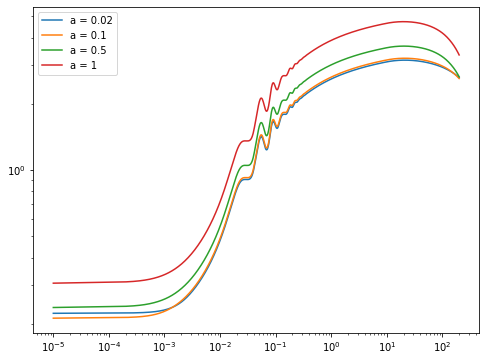

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for a in [0.02, 0.1, 0.5, 1]:
    pk = pyccl.linear_matter_power(cosmo, k_arr, a)
    pk_custom = pyccl.linear_matter_power(cosmo_custom, k_arr, a)
    pk_ratio = pk_custom / pk
    ax.loglog(k_arr, pk_ratio, label=f'a = {a}')
    
ax.legend()